In [1]:
# Загрузка данныхx
import src.data as d
import src.drawer as drawer
import numpy as np
import math
import importlib
importlib.reload(d)
importlib.reload(drawer)


source_data, markers = d.load_data("data/ocr.dat", 2, False)
# source_data, markers = d.load_compact_clusters(200, 10, alpha=1.0)
# source_data, markers = d.load_noise(200, 10)

# Попробовать очистить данные
source_data, markers = d.filter(source_data, markers, 2*3*math.sqrt(3))
print('filtered:', len(source_data[0]))

# Сортировка по дисперсии
source_std_dev = np.std(source_data,1)
d.sort(source_data, source_std_dev)

# Получаем ков. матрицу и собственные значения с векторами, сортируем
source_cov_mat = np.cov(source_data)
source_e_vals, source_e_vecs = np.linalg.eig(source_cov_mat)

file dim: 25
file len: 840
real len: 420
filtered: 420


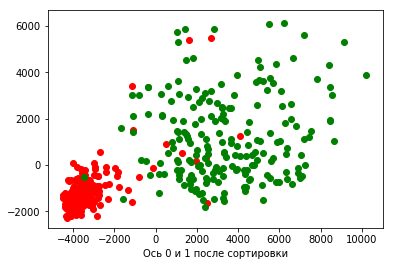

In [2]:
drawer.plot_2d(source_data, markers, 0,1, "Ось 0 и 1 после сортировки").show()

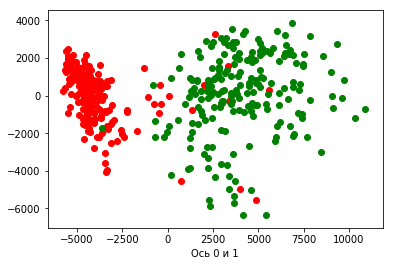


Квадрат относительной ошибки
1 : 0.8547
2 : 0.7018
3 : 0.6146
4 : 0.5479
5 : 0.4933
6 : 0.4413
7 : 0.4045
8 : 0.3734
9 : 0.3453
10 : 0.3203
11 : 0.3186
12 : 0.3143
13 : 0.3098
14 : 0.3021
15 : 0.2950
16 : 0.2887
17 : 0.2832
18 : 0.2574
19 : 0.2308
20 : 0.2141
21 : 0.1874
22 : 0.1599
23 : 0.1289
24 : 0.0914
25 : 0.0000


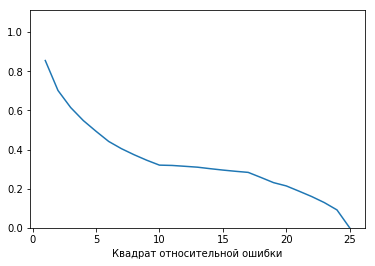

Размерность: 15


In [3]:
#PCA 
import src.pca as pca
importlib.reload(pca)

# Проекция
pca_data, pca_error = pca.calculate(source_data)
drawer.plot_2d(pca_data, markers, 0, 1, "Ось 0 и 1").show()

# Квадрат относительной ошибки
print("\nКвадрат относительной ошибки")
for i in range(len(pca_error)):
    print(i+1, ": %.4f" % pca_error[i])

drawer.plot_line(pca_error, label='Квадрат относительной ошибки').show()
print('Размерность:', d.real_dimensionality(pca_error, 0.3))

1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..


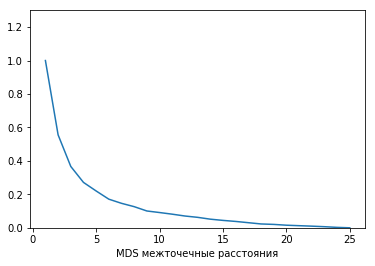

Размерность: 7


In [4]:
#MDS
import src.mds as mds
importlib.reload(mds)

mds_data_list = [] 
mds_distances = np.empty(len(source_data))
mds_prepared = mds.init(source_data)


for i in range(1, len(mds_distances)+1):
    print(i,end='..')
    proj, distance = mds_prepared.calculate(i, eps=0.0005)
    mds_data_list.append(proj)
    mds_distances[i-1] = distance
print()

mds_distances /= max(mds_distances)
drawer.plot_line(mds_distances, label='MDS межточечные расстояния').show()
print("Размерность:", d.real_dimensionality(mds_distances, 0.15))

1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..


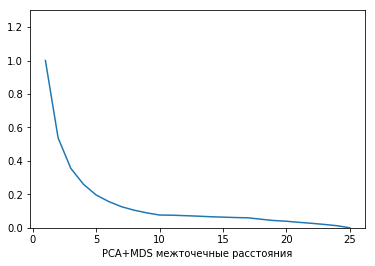

Размерность: 7


In [5]:
# PCA + MDS
import src.mds as mds
importlib.reload(mds)

pca_mds_data_list = [] 
pca_mds_distances = np.empty(len(pca_data))
pca_mds_prepared = mds.init(pca_data)


for i in range(1, len(pca_mds_distances)+1):
    print(i,end='..')
    proj, distance = pca_mds_prepared.calculate(i, eps=0.0005)
    pca_mds_data_list.append(proj)
    pca_mds_distances[i-1] = distance
print()

pca_mds_distances /= max(pca_mds_distances)
drawer.plot_line(pca_mds_distances, label='PCA+MDS межточечные расстояния').show()
print("Размерность:", d.real_dimensionality(pca_mds_distances, 0.15))

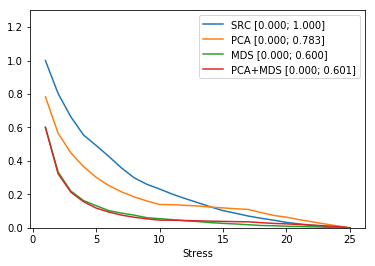

In [14]:
# Стресс-функция для PCA и MDS
importlib.reload(d)

src_stress_d = []
pca_stress_d = []
mds_stress_d = []
pca_mds_stress_d = []

for i in range(len(source_data)):
    src_stress_d.append(d.stress(source_data, source_data[:i+1]))
    pca_stress_d.append(d.stress(source_data, pca_data[:i+1]))
    mds_stress_d.append(d.stress(source_data, mds_data_list[i]))
    pca_mds_stress_d.append(d.stress(source_data, pca_mds_data_list[i]))

max_val = max(max(src_stress_d), max(src_stress_d), max(mds_stress_d), max(pca_mds_stress_d))

src_stress_d /= max_val
pca_stress_d /= max_val
mds_stress_d /= max_val
pca_mds_stress_d /= max_val

drawer.plot_multiline(
    [src_stress_d, pca_stress_d, mds_stress_d, pca_mds_stress_d], 
    label='Stress', 
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS']
    ).show()

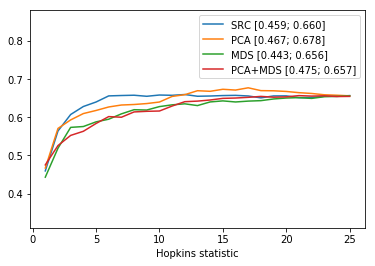

In [12]:
# Хопкинс
import src.hopkins as hopkins
importlib.reload(hopkins)

source_hopkins = []
pca_hopkins = []
mds_hopkins = []
pca_mds_hopkins = []

for i in range(1, len(source_data)+1): 
    source_hopkins.append(hopkins.calculate(source_data[:i]))
    pca_hopkins.append(hopkins.calculate(pca_data[:i]))
    mds_hopkins.append(hopkins.calculate(mds_data_list[i-1]))
    pca_mds_hopkins.append(hopkins.calculate(pca_mds_data_list[i-1]))

drawer.plot_multiline(
    [source_hopkins, pca_hopkins, mds_hopkins, pca_mds_hopkins], 
    label='Hopkins statistic', 
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS']
    ).show()

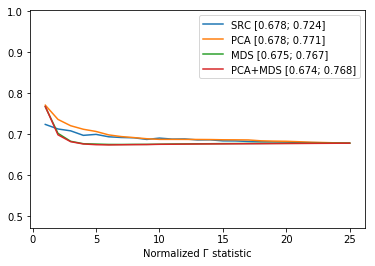

In [19]:
# Хуберт
"""
Почему при нормировании по дисперсии наблюдается линейный рост:
Потому что с добавлением новых призноков снижается std -> при делении точки располагаются дальше -> межточечное расстояние растет

Почему помогает нормализация по дистанции:
Т.к. межточечное расстояние растет, растет и max(dist) -> при делении это компенсирует рост расстояния

Почему нормализованная статистика не похожа на не нормализованную?
Так как при нормализации расстояния между кластерами становится -0.5:0.5, некоторые расстояния между
отдаленными точками в одном кластере вносят отрицательный вклад в общую оценку
"""

import src.hubert as hubert
from scipy.spatial import distance
importlib.reload(hubert)
importlib.reload(drawer)

source_hubert = []
pca_hubert = []
mds_hubert = []
pca_mds_hubert = []

# calculate Hubert Г statistic
def calc_hubert():
    for i in range(1, len(source_data)+1):
        source_hubert.append(hubert.calculate(source_data[:i], markers))
        pca_hubert.append(hubert.calculate(pca_data[:i], markers))
        mds_hubert.append(hubert.calculate(mds_data_list[i-1], markers))
        pca_mds_hubert.append(hubert.calculate(pca_mds_data_list[i-1], markers))

# calculate normalize Hubert Г statistic
def calc_hubert_norm():
    for i in range(1, len(source_data)+1):
        source_hubert.append(hubert.calculate_norm(source_data[:i], markers))
        pca_hubert.append(hubert.calculate_norm(pca_data[:i], markers))
        mds_hubert.append(hubert.calculate_norm(mds_data_list[i-1], markers))
        pca_mds_hubert.append(hubert.calculate_norm(pca_mds_data_list[i-1], markers))

# label = 'Hubert\'s Г statistic'
# calc_hubert()

label = 'Normalized Г statistic'
calc_hubert_norm()

drawer.plot_multiline(
    [source_hubert, pca_hubert, mds_hubert, pca_mds_hubert], 
    label=label,
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS']
    ).show()

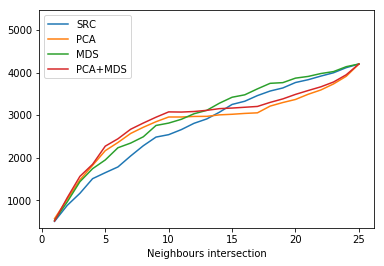

In [17]:
# Оценка сохранения формы размещения данных после преобразований
# Чем больше - тем лучше сохранилась форма

importlib.reload(d)

def intersect_sum(s1, s2):
    res_sum = 0
    for i in range(len(s1)):
        res_sum += len(s1[i] & s2[i])
    return res_sum

ngbrs_num = 10
sourse_nbrs = d.points_neighbours(source_data,ngbrs_num)
src_nbrs_error = []
pca_nbrs_error = []
mds_nbrs_error = []
pca_mds_nbrs_error = []


for i in range(len(source_data)):
    src_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(source_data[:i+1],ngbrs_num)))
    pca_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(pca_data[:i+1],ngbrs_num)))
    mds_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(mds_data_list[i],ngbrs_num)))
    pca_mds_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(pca_mds_data_list[i],ngbrs_num)))

drawer.plot_multiline(
    [src_nbrs_error, pca_nbrs_error, mds_nbrs_error, pca_mds_nbrs_error], 
    label='Neighbours intersection', 
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS'],
    show_range=False
    ).show()

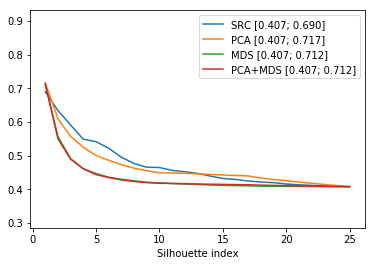

In [16]:
"""
Силуэт-индекс - от -1 до 1
Высокие значения говорят о том, что объект хорошо соотносится со своим кластером
и плохо с другим. Если значение высокое, то это хорошая конфигурация кластеров. 

https://en.wikipedia.org/wiki/Silhouette_(clustering)
"""

import src.silhouette  as sil
importlib.reload(sil)

src_sil = []
pca_sil = []
mds_sil = []
pca_mds_sil = []

for i in range(len(source_data)):
    src_sil.append(sil.calculate(source_data[:i+1], markers))
    pca_sil.append(sil.calculate(pca_data[:i+1], markers))
    mds_sil.append(sil.calculate(mds_data_list[i], markers))
    pca_mds_sil.append(sil.calculate(pca_mds_data_list[i], markers))

drawer.plot_multiline(
    [src_sil, pca_sil, mds_sil, pca_mds_sil], 
    label='Silhouette index', 
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS']
    ).show()